In [119]:
%load_ext autoreload
%autoreload 2

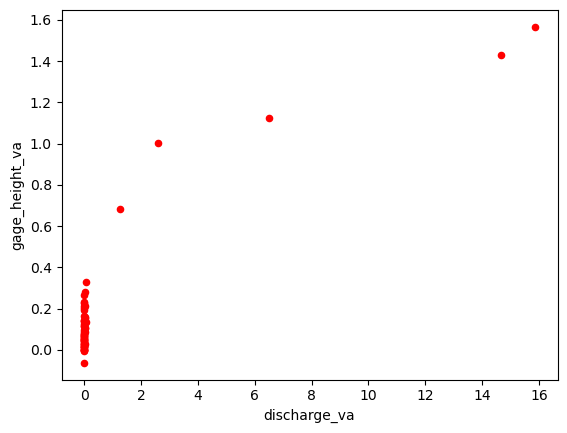

In [5]:
curve_file = pd.read_csv("res/rating_curves_clear/09423350.txt", sep="\t", comment="#")
curve_file = curve_file[["site_no", "measurement_dt", "gage_height_va", "discharge_va"]]
curve_file = curve_file.dropna().drop(0).reset_index(drop=True)
curve_file["measurement_dt"] = pd.to_datetime(
    curve_file["measurement_dt"], format="mixed"
)
curve_file = curve_file.set_index("measurement_dt")
curve_file[["gage_height_va", "discharge_va"]] = curve_file[
    ["gage_height_va", "discharge_va"]
].astype(float)
curve_file["gage_height_va"] *= 0.3
curve_file["discharge_va"] *= 0.028316832

ax1 = curve_file.plot.scatter(x="discharge_va", y="gage_height_va", c="Red");

[[Model]]
    (Model(power_function) / Model(line))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 450
    # data points      = 59
    # variables        = 4
    chi-square         = 0.26644474
    reduced chi-square = 0.00484445
    Akaike info crit   = -310.607424
    Bayesian info crit = -302.297275
    R-squared          = 0.95622234
[[Variables]]
    amp:        1.35015137 +/- 0.01289687 (0.96%) (init = 1)
    cen:       -1.6200e-05 +/- 1.6868e-05 (104.12%) (init = 0)
    intercept: -4.7832e-04 +/- 1.5104e-04 (31.58%) (init = 0.001)
    wid:        1.68938774 +/- 0.05657050 (3.35%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(cen, intercept) = +0.9822
    C(amp, wid)       = +0.6659
    C(amp, cen)       = +0.1654
    C(cen, wid)       = +0.1227


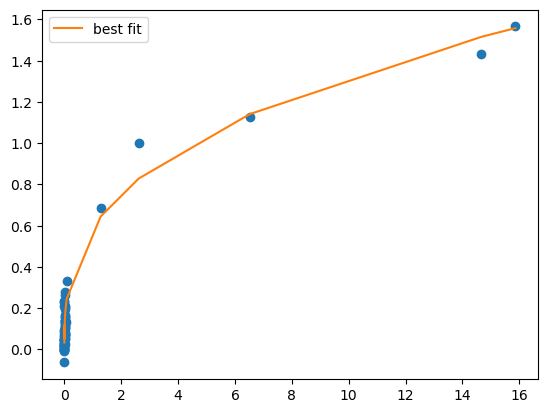

In [122]:
# <examples/doc_model_composite.py>
import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt

from lmfit import Model


from lmfit import CompositeModel, Model
from lmfit.models import LinearModel, ExpressionModel

# create data from broadened step
x = curve_file["discharge_va"].to_numpy()
y = curve_file["gage_height_va"].to_numpy()


def power_function(x, amp, cen):
    return (x**amp) + cen


def line(x, intercept, wid):
    """a line"""
    return wid * x + intercept


mod = Model(power_function) / Model(line)
pars = mod.make_params(amp=1, cen=0, wid=1, intercept=0.001)

result = mod.fit(y, pars, x=x)
print(result.fit_report())

plt.plot(x, y, "o")
plt.plot(x, result.best_fit, "-", label="best fit")
plt.legend()
plt.show()

[[Model]]
    (Model(power_function) / Model(line))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 450
    # data points      = 59
    # variables        = 4
    chi-square         = 0.26644474
    reduced chi-square = 0.00484445
    Akaike info crit   = -310.607424
    Bayesian info crit = -302.297275
    R-squared          = 0.95622234
[[Variables]]
    power:  1.35015137 +/- 0.01289687 (0.96%) (init = 1)
    c:     -1.6200e-05 +/- 1.6868e-05 (104.12%) (init = 0)
    b:     -4.7832e-04 +/- 1.5104e-04 (31.58%) (init = 0.001)
    slope:  1.68938774 +/- 0.05657050 (3.35%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, b)         = +0.9822
    C(power, slope) = +0.6659
    C(power, c)     = +0.1654
    C(c, slope)     = +0.1227


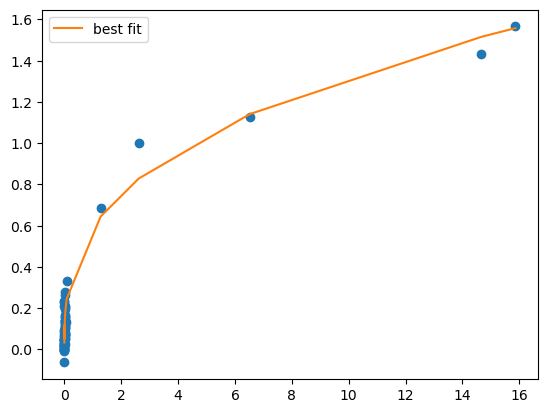

In [125]:
from scripts.lmfit_model import pars

result = custom_model.fit(y, pars, x=x)
print(result.fit_report())

plt.plot(x, y, "o")
plt.plot(x, result.best_fit, "-", label="best fit")
plt.legend()
plt.show()

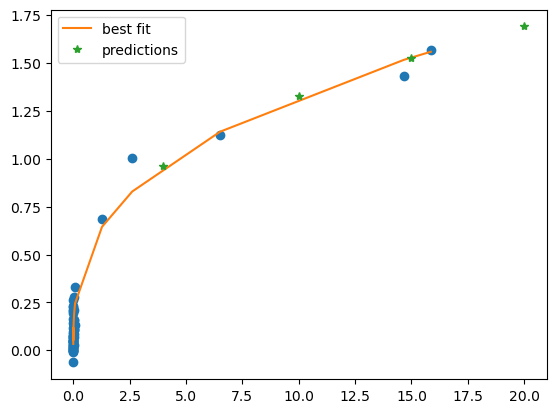

In [116]:
new_x = [10, 4, 20, 15]
new_y = [result.eval(x=i, params=result.params) for i in new_x]

plt.plot(x, y, "o")
# plt.plot(x, result.init_fit, "--", label="initial fit")
plt.plot(x, result.best_fit, "-", label="best fit")
plt.plot(new_x, new_y, "*", label="predictions")
plt.legend()
plt.show()

In [109]:
with open("test.json", "r") as f:
    params = result.params.load(f)


### Read rating curve and build up an equation parameters

In [280]:
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from scripts.lmfit_model import division_model, sum_model
from sklearn.metrics import mean_squared_error

available_gauges = list(i.stem for i in Path("out/rating_curves/").glob("*.csv"))
counter = 0
for gauge_id in tqdm(available_gauges):

    field_data = pd.read_csv(
        f"out/rating_curves/{gauge_id}.csv",
        index_col="date",
        parse_dates=True,
        dtype={"gauge_id": str},
    )
    field_data = field_data.sort_values(by="q_cms")

    if len(field_data) < 4:
        continue
    y = field_data["lvl_m"].to_numpy()
    x = field_data["q_cms"].to_numpy()

    try:
        use_model = None
        use_model = division_model
        pars = use_model.make_params(
            power={"min": 0.001, "value": 0.1},
            c={"value": 0},
            slope={"value": 1, "min": 0},
            b={"value": 0},
        )
        result = use_model.fit(y, pars, x=x)
        error_res = mean_squared_error(y, result.best_fit, squared=False)
        if error_res < 0.5:
            with open(f"out/fit_params/{gauge_id}_div.json", "w") as f:
                result.params.dump(f)
        else:
            counter += 1
            print(f"Bullshit ! for Gauge with ID {gauge_id} error is {error_res}")
    except ValueError:
        use_model = None
        use_model = sum_model
        pars = use_model.make_params(
            power={"min": 0.001, "value": 0.1},
            c={"value": 0},
            slope={"value": 1, "min": 0},
            b={"value": 0},
        )
        result = use_model.fit(y, pars, x=x)

        error_res = mean_squared_error(y, result.best_fit, squared=False)
        if error_res < 0.5:
            with open(f"out/fit_params/{gauge_id}_sum.json", "w") as f:
                result.params.dump(f)
        else:
            counter += 1
            print(f"Bullshit ! for Gauge with ID {gauge_id} error is {error_res}")
print(f"Shit data for {counter} gauges out from {len(available_gauges)}")

# TODO wtf happened to field measurements
# Generate sample y
# np.random.seed(0)

# # Change Point Detection
# model = "l2"  # Least squares estimation
# algo = rpt.Pelt(model=model).fit(y)
# rupture = algo.predict(pen=15)

# # Display results
# if len(rupture) == 1:
#     continue
# span = rupture[1] - rupture[0]
# if span > 50:
#     print(f"{gauge_id}\n")
#     rpt.display(y, rupture)
#     plt.show()

  0%|          | 0/1008 [00:00<?, ?it/s]

Bullshit ! for Gauge with ID 10257550 error is 0.5523036903333794
Bullshit ! for Gauge with ID 11289850 error is 1.4724440424516152
Bullshit ! for Gauge with ID 10255810 error is 0.6733156304131206
Bullshit ! for Gauge with ID 09527600 error is 5.0053262906296645
Bullshit ! for Gauge with ID 09429200 error is 0.7951689615448041
Bullshit ! for Gauge with ID 11289500 error is 111.8079718310252
Bullshit ! for Gauge with ID 11285500 error is 1.5184854922650044
Bullshit ! for Gauge with ID 10270885 error is 1.3905237861502688
Bullshit ! for Gauge with ID 11274538 error is 0.8312193818360385
Bullshit ! for Gauge with ID 11351948 error is 5.204088325955397
Bullshit ! for Gauge with ID 09525000 error is 1.3062577446799248
Bullshit ! for Gauge with ID 11323500 error is 6.367390797156868
Bullshit ! for Gauge with ID 09429000 error is 2.1839717466668382
Bullshit ! for Gauge with ID 11406900 error is 0.7146274746361487
Bullshit ! for Gauge with ID 11140585 error is 0.7348367416965352
Bullshit ! fo

In [281]:
print(f"Shit data for {counter} gauges out from {len(available_gauges)}")

Shit data for 107 gauges out from 1008
